# Clustering - Pokémon

## Aim
Categorise Pokémon based on their stats, e.g., attack, defense, special attack, special defense, speed, and HP

## Method

### Data
The dataset was be downloaded from [Kaggle](https://www.kaggle.com/datasets/rounakbanik/pokemon?resource=download). It contains the 41 columns. Only the features were investigated. 
- `name`: The English name of the Pokemon
- `pokedex_number`: The entry number of the Pokemon in the National Pokedex
- `attack`: The Base Attack of the Pokemon
- `defense`: The Base Defense of the Pokemon
- `sp_attack`: The Base Special Attack of the Pokemon
- `sp_defense`: The Base Special Defense of the Pokemon
- `hp`: The Base HP of the Pokemon
- `speed`: The Base Speed of the Pokemon
- `generation`: The numbered generation which the Pokemon was first introduced
- `is_legendary`: Denotes if the Pokemon is legendary

### Algorithm
Given a dataset $\{x^{(i)}, y^{(i)}\}_{i=1}^{m}$, choose the number of clusters $K$, where $K < m$. Denote $c^{(i)}$ as the cluster that the $i$-th example is assigned to, and $S_k$ as the set of data points assigned to cluster $k$.
1. Randomly initialise $K$ cluster centroids $\mu_{1}, \mu_{2}, ..., \mu_{K}$ *i.e.* the points in the feature space that represent the centre of each cluster. In practice, just randomly pick $K$ training examples and set $\mu_{1}, \mu_{2}, ..., \mu_{K}$ equal to these $K$ examples
2. For each data point, calculate the distance to each centroid and assign the data point to the cluster whose centroid is closest $$c^{(i)} = \underset{k \in \{1,2,...,K\}}{\text{arg min}} \| x^{(i)} - \mu_{k}\|^{2}_{2}$$
3. For each cluster, calculate the mean of all data points assigned to that cluster and move the cluster centroid to the calculated mean $$\mu_{k} = \frac{1}{|S_{k}|}\sum\limits_{i \in S_{k}} x^{(i)}$$
4. Repeat Step 2 and 3 until the assignment of data points to clusters no longer changes or changes very minimally
5. Compute cost function $$J(c^{(1)}, ..., c^{(m)}, \mu_{1}, ..., \mu_{K}) = \frac{1}{m} \sum\limits_{i=1}^{m} || x^{(i)} - \mu_{c^{(i)}}||^{2}$$
6. Repeat steps 1 to 5 around 50 ~ 1000 times and pick the set of clusters giving lowest cost $J$

## Analysis

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly
import plotly.express as px
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


### Import data

In [98]:
df0 = pd.read_csv("./data/pokemon.csv")

In [99]:
df0.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

In [100]:
columns = ['pokedex_number', 'attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'speed']
condition_generation = df0['generation'].isin([1,2,3])
df = df0.loc[condition_generation, columns]
df.set_index('pokedex_number', inplace=True)
df.head(10)

,attack,defense,sp_attack,sp_defense,hp,speed
pokedex_number,,,,,,
1,49,49,65,65,45,45
2,62,63,80,80,60,60
3,100,123,122,120,80,80
4,52,43,60,50,39,65
5,64,58,80,65,58,80
6,104,78,159,115,78,100
7,48,65,50,64,44,43
8,63,80,65,80,59,58
9,103,120,135,115,79,78


### Data checking

#### Dimension

In [101]:
df.shape

(386, 6)

#### Data type

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386 entries, 1 to 386
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   attack      386 non-null    int64
 1   defense     386 non-null    int64
 2   sp_attack   386 non-null    int64
 3   sp_defense  386 non-null    int64
 4   hp          386 non-null    int64
 5   speed       386 non-null    int64
dtypes: int64(6)
memory usage: 21.1 KB


### Data exploration

#### Summary statistics

In [103]:
df.describe()

,attack,defense,sp_attack,sp_defense,hp,speed
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,74.274611,71.417098,69.121762,69.795337,66.525907,65.639896
std,32.599932,33.588335,32.296487,29.380744,28.237133,29.491225
min,5.000000,5.000000,10.000000,20.000000,1.000000,5.000000
25%,50.000000,50.000000,45.000000,50.000000,50.000000,45.000000
50%,70.000000,65.000000,65.000000,65.000000,64.000000,65.000000
75%,95.000000,90.000000,90.000000,85.000000,80.000000,85.000000
max,185.000000,230.000000,194.000000,230.000000,255.000000,180.000000


#### Distribution

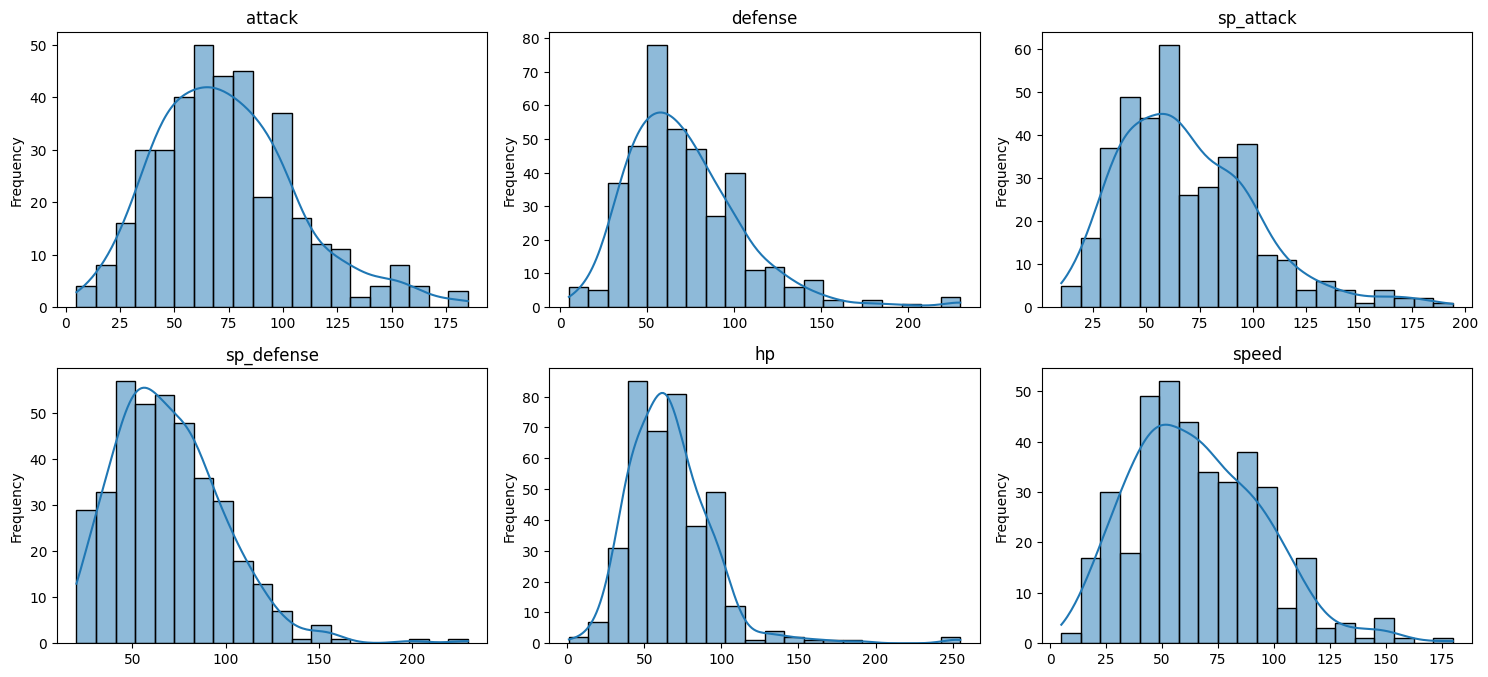

In [104]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns):
    plt.subplot(3, 3, i + 1) 
    sns.histplot(df[column], bins=20, kde=True) 
    plt.title(f'{column}')
    plt.xlabel("")
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#### Data pre-processing

In [105]:
columns_to_scale = ['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'speed']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

### K-mean clustering

In [106]:
k_values = range(1, 11)
inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)  
    kmeans.fit(df[columns_to_scale])
    inertia.append(kmeans.inertia_) 

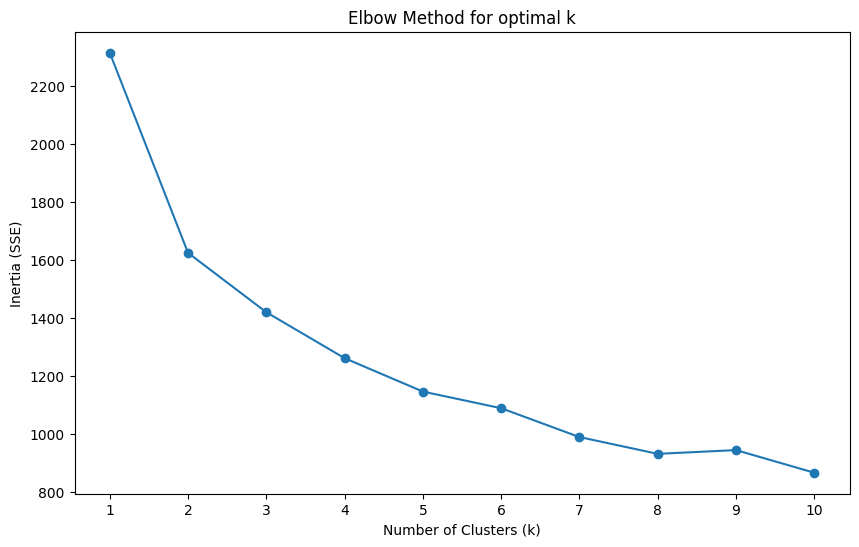

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.xticks(k_values)
plt.show()

In [108]:
kl = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
optimal_k = kl.elbow
print(f"The optimal number of clusters: {optimal_k}")

The optimal number of clusters: 3


#### Evaluation

In [109]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df['cluster'] = kmeans.fit_predict(df[columns_to_scale])

In [110]:
silhouette_avg = silhouette_score(df[columns_to_scale], df['cluster'])
print(f'Silhouette Score for k = {optimal_k}: {silhouette_avg:.3f}')

Silhouette Score for k = 3: 0.233


* The Silhouette Score closer to 1 means better-defined clusters, while the score closer to -1 indicates poor clustering or overlapping clusters
* Silhouette Score of 0.233 indicates that the clustering is not very strong

In [111]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df[columns_to_scale])
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
# df_pca['cluster'] = kmeans.labels_
df_pca.index = df.index

In [112]:
df_details = pd.merge(df_pca, df['cluster'], left_index=True, right_index=True, how='inner')
columns = ['name', 'pokedex_number', 'attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'speed', 'is_legendary']
temp1 = df0.loc[condition_generation, columns].copy()
temp1.set_index('pokedex_number', inplace=True)
df_details = pd.merge(df_details, temp1, left_index=True, right_index=True, how='inner')

In [167]:
df_details['cluster'].astype(str).unique()

array(['1', '2', '0'], dtype=object)

In [168]:
def interactive_plot(dataframe):
    temp_df = dataframe.reset_index(drop=False)
    temp_df['cluster'] = temp_df['cluster'].astype(str)
    cluster_order = np.sort(temp_df['cluster'].unique())
    fig = px.scatter(
        temp_df,
        x='PC1',
        y='PC2',
        color='cluster',
        category_orders={'cluster': cluster_order},   
        hover_name='name',
        hover_data={
            'pokedex_number': True,
            'attack': True,
            'defense': True,
            'sp_attack': True,
            'sp_defense': True,
            'hp': True,
            'speed': True,
            'is_legendary': True,
        },
        title='PCA of Pokémon Clusters',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},)
    fig.show()

In [169]:
interactive_plot(df_details)

* Caution: The clusters might appear to overlap in the PCA plot even though they are well-separated in the original feature space.
* The performance of k-means clustering is not bad
* At least, it can roughly separate Pokémon before and after evolution

### DBSCAN

In [116]:
def optimise_epsilon(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])

    kl = KneeLocator(range(1, len(distances) + 1), distances, curve="convex", direction="increasing")
    optimal_eps = distances[kl.knee]
    
    plt.figure(figsize=(6, 3))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()
    
    return optimal_eps

In [117]:
df1 = df.copy().drop(["cluster"], axis=1)
df1.head()

,attack,defense,sp_attack,sp_defense,hp,speed
pokedex_number,,,,,,
1,-0.776303,-0.668273,-0.127788,-0.163425,-0.763316,-0.700774
2,-0.377011,-0.250921,0.337261,0.347776,-0.231411,-0.191488
3,0.790148,1.537732,1.639400,1.710979,0.477796,0.487560
4,-0.684159,-0.847139,-0.282805,-0.674626,-0.976078,-0.021726
5,-0.315582,-0.399976,0.337261,-0.163425,-0.302331,0.487560


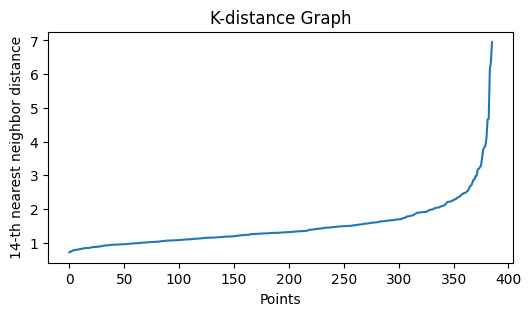

In [160]:
min_samples = 2 * df1.shape[1]
# min_samples = 2
epsilon = optimise_epsilon(df1, k=min_samples)

In [161]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

#### Evaluation

In [162]:
df1['cluster'] = dbscan.fit_predict(df1[columns_to_scale])
silhouette_avg = silhouette_score(df1[columns_to_scale], df1['cluster'])
print(f'Clusters: {", ".join(df1["cluster"].unique().astype(str))}')
print(f'Silhouette Score: {silhouette_avg:.3f}')

Clusters: 0, -1
Silhouette Score: 0.523


* Higher Silhouette Score (0.506) suggests better-defined clusters compared to K-Means
* However, DBSCAN found only one cluster exists and the rest of the points are noise

In [163]:
df1_details = pd.merge(df_pca, df1['cluster'], left_index=True, right_index=True, how='inner')
columns = ['name', 'pokedex_number', 'attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'speed', 'is_legendary']
temp1 = df0.loc[condition_generation, columns].copy()
temp1.set_index('pokedex_number', inplace=True)
df1_details = pd.merge(df1_details, temp1, left_index=True, right_index=True, how='inner')

In [170]:
interactive_plot(df1_details)

In [165]:
df1_details[df1_details["cluster"]==-1]

,PC1,PC2,cluster,name,attack,defense,sp_attack,sp_defense,hp,speed,is_legendary
pokedex_number,,,,,,,,,,,
113,0.459615,-0.303971,-1,Chansey,5,5,35,105,250,50,0
202,-0.278497,-1.332770,-1,Wobbuffet,33,58,33,58,190,33,0
208,2.366985,-4.174636,-1,Steelix,125,230,55,95,75,30,0
213,1.387925,-4.876473,-1,Shuckle,10,230,10,230,20,5,0
242,1.755389,-0.002718,-1,Blissey,10,10,75,135,255,55,0
306,2.563669,-3.645714,-1,Aggron,140,230,60,80,70,50,0
378,2.520249,-0.935806,-1,Regice,50,100,100,200,80,50,1


* Since this analysis is to look for multiple cluster, DBSCAN is not the right fit. 

## Discussion
* Possible issues could be related to the parameter selection in DBSCAN, the choice of algorithm, or the nature of the data
* Regarding parameter selection, smaller `min_samples` were tested to detect smaller clusters. However, the performance is still not good. Only one main cluster was identified
* Regarding the choice of algorithm, Agglomerative Hierarchical Clustering could be explored to determine if it better captures the data structure
* Regarding the nature of the data, the data may only have 1 dense region